# Tomographic reconstruction of a 2D phase space distribution

In [1]:
import sys
import importlib
import numpy as np
from matplotlib import pyplot as plt
import proplot as pplt
import seaborn as sns
from tqdm import tqdm, trange
from skimage.transform import radon
from skimage.transform import iradon
from scipy import interpolate

import reconstruct as rec
from tools import ap
from tools import plotting as mplt
from tools import utils

In [2]:
pplt.rc['axes.grid'] = False
pplt.rc['cmap.discrete'] = False
pplt.rc['cmap.sequential'] = 'dusk_r'
pplt.rc['cmap.diverging'] = 'Vlag'
pplt.rc['figure.facecolor'] = 'white'

## Setup 

Create a distribution (Gaussian + four small Gaussian spots).

In [3]:
n = 100000  # number of particles
eps = 10.0  # emittance [mm mrad]
alpha = -0.7  # Twiss parameter
beta = 15.0  # Twiss parameter [m/rad]
V = ap.norm_matrix(alpha, beta)  # normalization matrix
A = np.sqrt(np.diag([eps, eps]))  # scale by emittances

# Generate particles in normalized phase space.
offset = 2.0  # distance from origin to spots
X_true_n = np.vstack([
    np.random.normal(scale=[1.0, 1.0], loc=[0.0, 0.0], size=(n, 2)),
    np.random.normal(scale=0.6, loc=[+offset, +offset], size=(n // 5, 2)),
    np.random.normal(scale=0.6, loc=[+offset, -offset], size=(n // 5, 2)),
    np.random.normal(scale=0.6, loc=[-offset, +offset], size=(n // 5, 2)),
    np.random.normal(scale=0.6, loc=[-offset, -offset], size=(n // 5, 2)),
])
X_true_n /= np.sqrt(np.linalg.det(np.cov(X_true_n.T)))
X_true_n = utils.apply(A, X_true_n)
X_true = utils.apply(V, X_true_n)

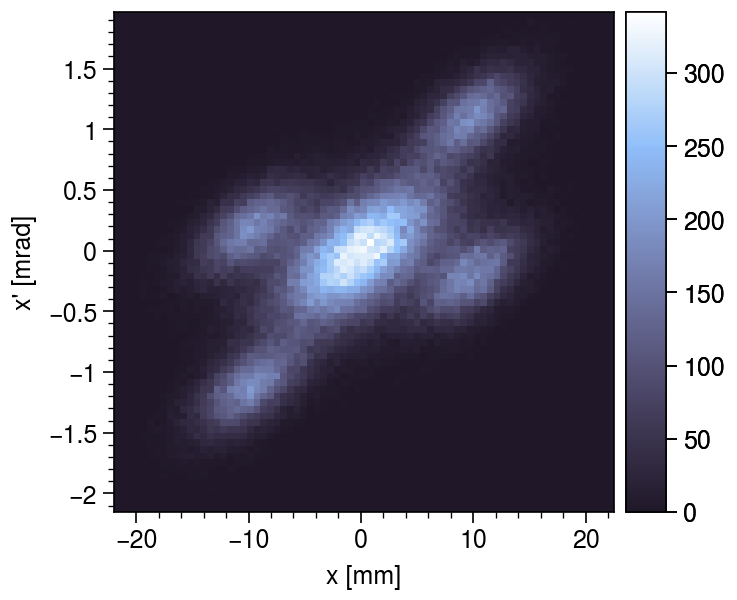

In [4]:
fig, ax = pplt.subplots()
sns.histplot(x=X_true[:, 0], y=X_true[:, 1], ax=ax,
             thresh=None, cmap='dusk_r', colorbar=True, bins=75)
ax.format(xlabel="x [mm]", ylabel="x' [mrad]")

Define the reconstruction grid in normalized phase space.

In [5]:
n_bins = 75
maxs_n = np.array([
    np.sqrt(4.0 * eps),
    np.sqrt(4.0 * eps),
])
maxs_n *= 1.0
limits_n = np.array([(-m, m) for m in maxs_n])
f_true_n, edges_rec = np.histogramdd(X_true_n, n_bins, limits_n)
grid_rec = [
    utils.get_bin_centers(edges_rec[0]),
    utils.get_bin_centers(edges_rec[1]),
]

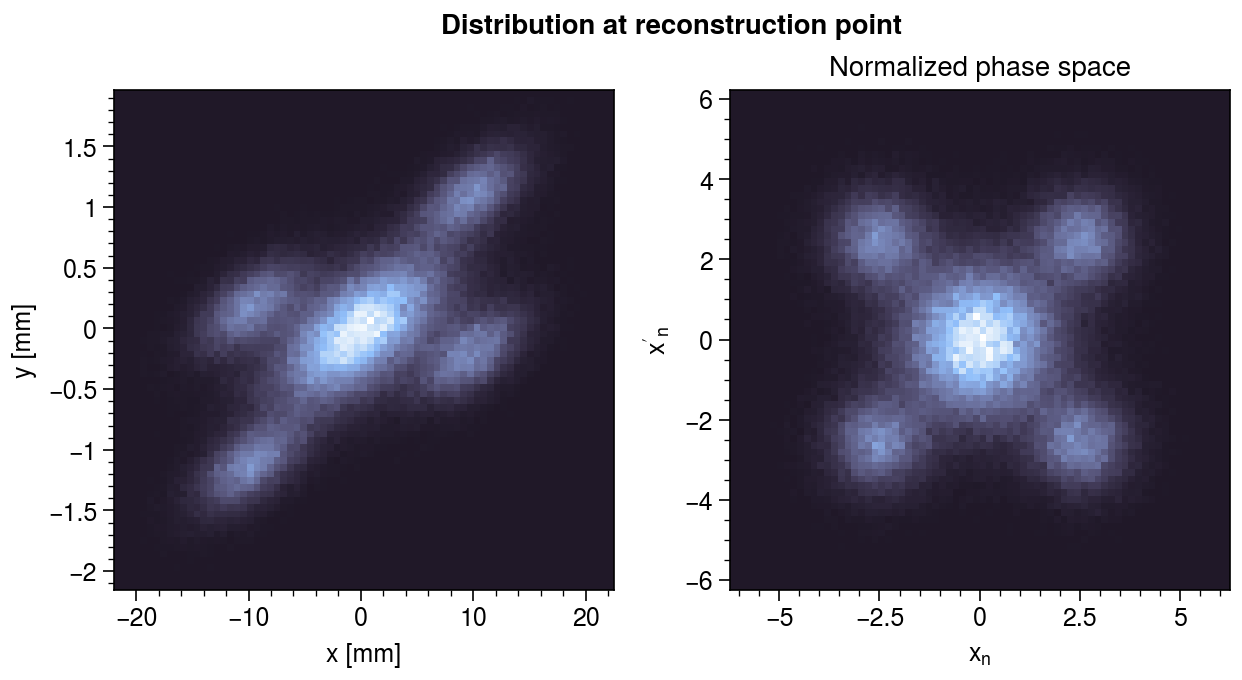

In [6]:
fig, axes = pplt.subplots(ncols=2, sharex=False, sharey=False)
axes[0].hist2d(X_true[:, 0], X_true[:, 1], bins=n_bins)
axes[1].hist2d(X_true_n[:, 0], X_true_n[:, 1], bins=grid_rec)
axes[0].format(xlabel="x [mm]", ylabel="y [mm]", title='')
axes[1].format(xlabel=r"$x_n$", ylabel=r"$x'_n$", title='Normalized phase space')
axes.format(suptitle='Distribution at reconstruction point')
plt.show()

## Simulate measurement

We will scan the phase advance in a 180 degree range, then let $\alpha$ and $\beta$ take random values at the measurement location.

In [7]:
n_proj = 15
phase_advances = np.linspace(0.0, np.pi, n_proj, endpoint=False)
betas = np.random.uniform(55.0, 75.0, size=n_proj)
alphas = np.random.uniform(-1.5, +1.5, size=n_proj)
xmax_meas = 65.0 # [mm]
edges_meas = np.linspace(-xmax_meas, xmax_meas, n_bins + 1)
grid_meas = 0.5 * (edges_meas[:-1] + edges_meas[1:])

In [8]:
tmats, projections = [], []
for k in trange(n_proj):
    # Compute the linear transfer matrix to the screen.
    V2 = ap.norm_matrix(alphas[k], betas[k])
    P = ap.phase_adv_matrix(phase_advances[k])
    M = np.linalg.multi_dot([V2, P, np.linalg.inv(V)])
    tmats.append(np.linalg.multi_dot([M, V]))
    # Transport the distribution to the screen.
    X_meas = utils.apply(M, X_true)    
    # Compute the projection on the screen.
    projection, _ = np.histogram(X_meas[:, 0], edges_meas)
    projections.append(projection / np.sum(projection))

100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


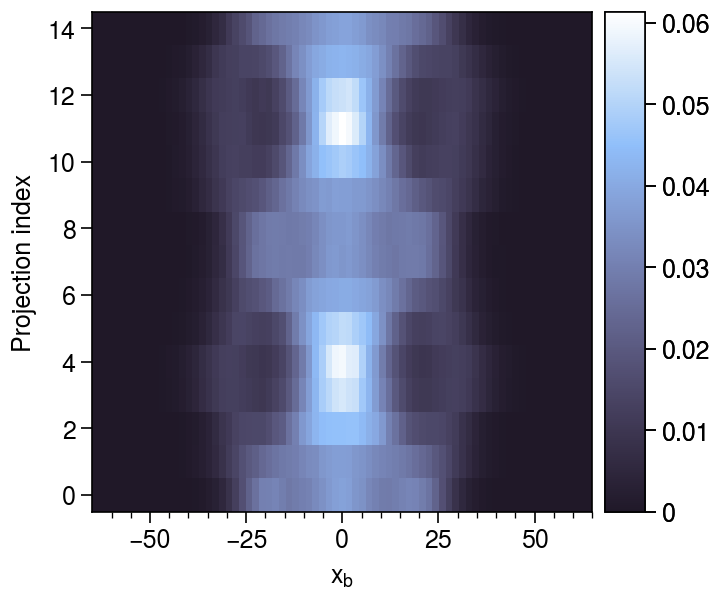

In [9]:
fig, ax = pplt.subplots()
ax.pcolormesh(grid_meas, np.arange(n_proj), projections, ec='None', colorbar=True,)
ax.format(xlabel=r'$x_b$', ytickminor=False, ylabel='Projection index')
plt.show()

## Reconstruct 

In [10]:
xx_meas = grid_meas
xx_rec = grid_rec[0]
proc_kws = dict(keep_positive=True)
f_rec_n = rec.rec2D(projections, tmats, xx_meas, xx_rec, method='SART', proc_kws=proc_kws, iterations=5)

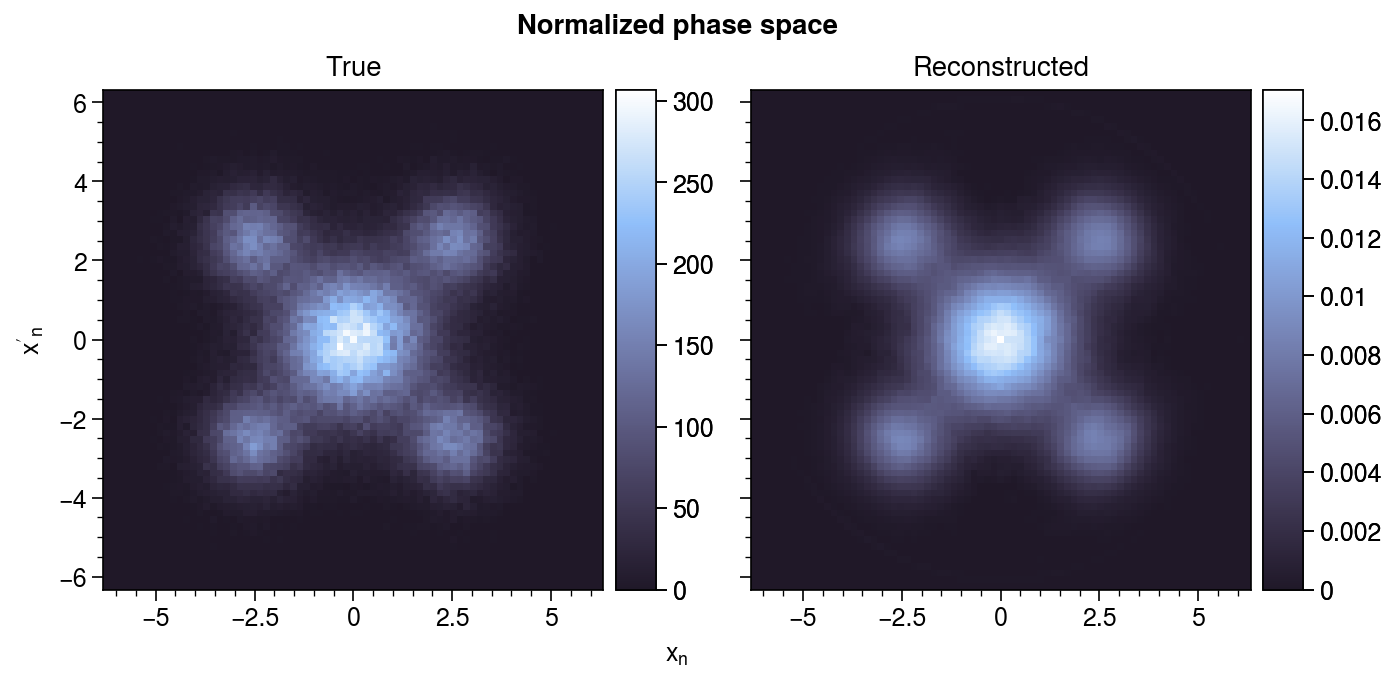

In [11]:
fig, axes = pplt.subplots(ncols=2)
plot_kws = dict(ec='None', colorbar=True)
axes[0].pcolormesh(grid_rec[0], grid_rec[1], f_true_n.T, **plot_kws)
axes[1].pcolormesh(grid_rec[0], grid_rec[1], f_rec_n.T, **plot_kws)
axes[0].set_title('True')
axes[1].set_title('Reconstructed')
axes.format(xlabel=r'$x_n$', ylabel=r"$x'_n$", suptitle='Normalized phase space')
plt.show()

In [12]:
# Transform out of normalized phase space.
f_rec, grid_rec_ = rec.transform(f_rec_n, V, grid_rec)
f_rec = np.clip(f_rec, 0.0, None)

# Bin the true distribution on the grid.
edges_rec_ = [
    rec.get_bin_edges(grid_rec_[0]),
    rec.get_bin_edges(grid_rec_[1]),
]
f_true, _ = np.histogramdd(X_true, bins=edges_rec_)

f_rec = f_rec / np.max(f_rec)
f_true = f_true / np.max(f_true)

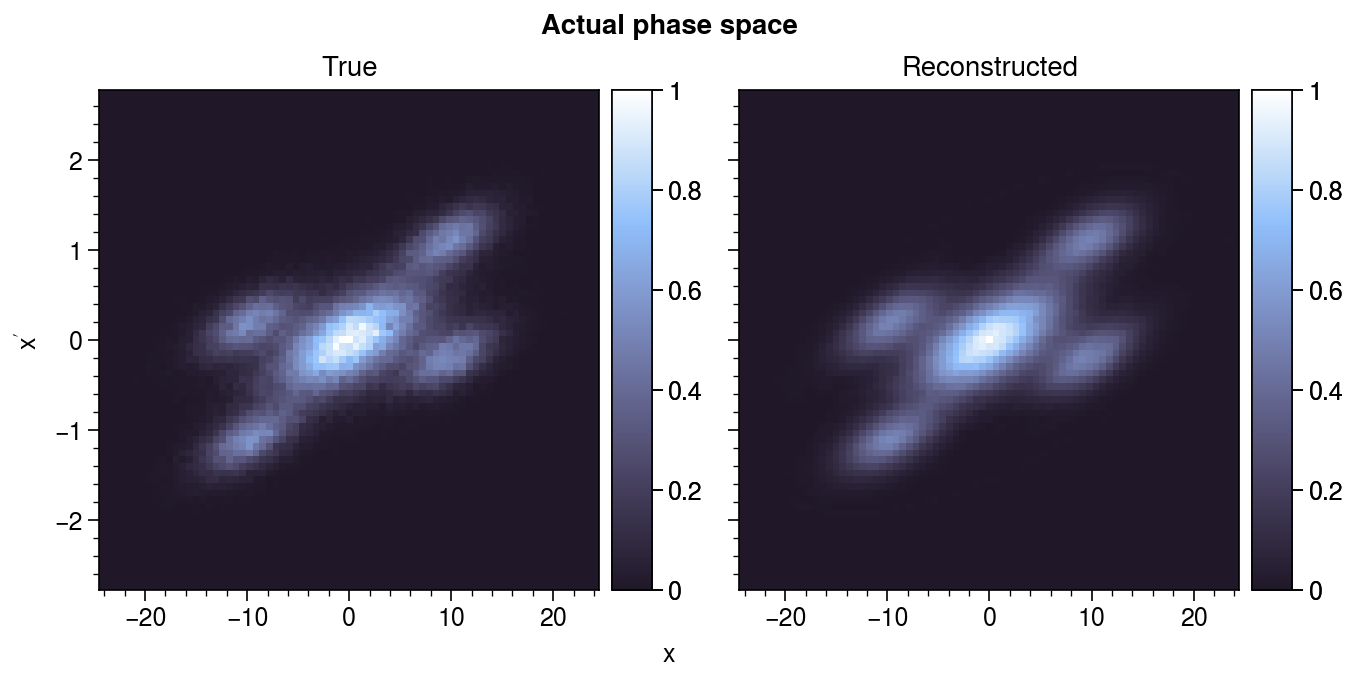

In [13]:
fig, axes = pplt.subplots(ncols=2)
for ax, _f in zip(axes, [f_true, f_rec]):
    mplt.plot_image(_f, x=grid_rec_[0], y=grid_rec_[1], ax=ax, colorbar=True)
axes[0].set_title('True')
axes[1].set_title('Reconstructed')
axes.format(xlabel=r'$x$', ylabel=r"$x'$",
            suptitle='Actual phase space')
plt.show()

## Aside: accuracy vs. number of projections and angular range

In [14]:
from skimage.transform import radon, iradon_sart, iradon

n_bins = 50
limits = [(grid_rec[0][0], grid_rec[0][-1]), (grid_rec[1][0], grid_rec[1][-1])]
z_true, _, _ = np.histogram2d(X_true_n[:, 0], X_true_n[:, 1], bins=n_bins, 
                              range=limits, density=True)

n_proj_list = np.arange(3, 30)
max_angles = np.linspace(5., 180., 50, endpoint=False)
errors = np.zeros((len(n_proj_list), len(max_angles)))    
for i in trange(errors.shape[0]):
    for j in range(errors.shape[1]):
        angles = np.linspace(0., max_angles[j], n_proj_list[i])
        projections = radon(z_true, theta=angles, circle=True)
        z = iradon_sart(projections, theta=angles)
        for _ in range(1):
            z = iradon_sart(projections, theta=angles, image=z)
        z = rec.process(z, keep_positive=True, density=True, limits=limits)
        errors[i, j] = np.sqrt(np.sum((z - z_true)**2))

  0%|          | 0/27 [00:00<?, ?it/s]/Users/austin/opt/anaconda3/lib/python3.9/site-packages/skimage/transform/radon_transform.py:83: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '
100%|██████████| 27/27 [00:13<00:00,  1.97it/s]


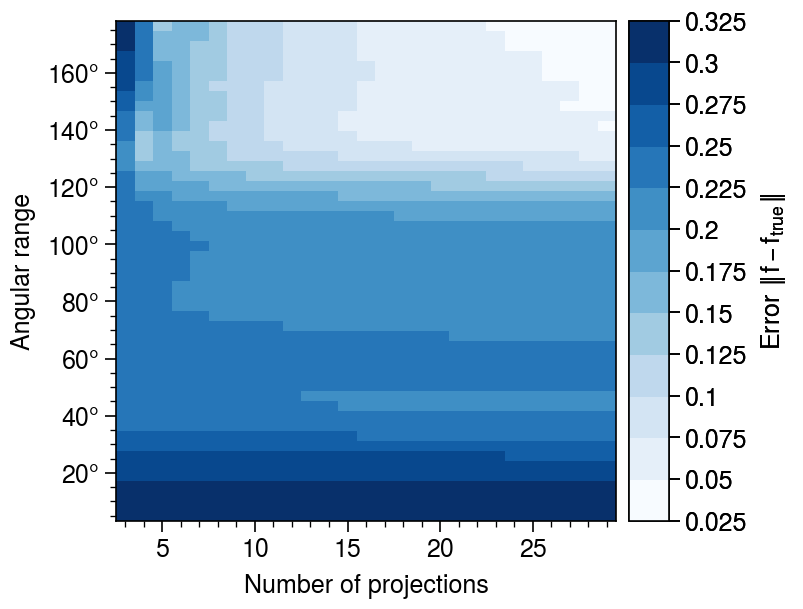

In [17]:
fig, ax = pplt.subplots()
mplt.plot_image(
    errors,
    x=n_proj_list, 
    y=max_angles,
    ax=ax,
    discrete=True,
    cmap='blues',
    colorbar=True, 
    colorbar_kw=dict(label=r'Error $\Vert f - f_{true} \Vert$')
)
ax.format(yformatter='deg', ylabel='Angular range', xlabel='Number of projections')
plt.show()